<a href="https://colab.research.google.com/github/Krishnakanth1993/Learnings/blob/main/MNIST_Model/Reference/minimal_prameter_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [24]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [25]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([512, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([512])


# **Data Loading & Preprocessing**

In [26]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [27]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [28]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


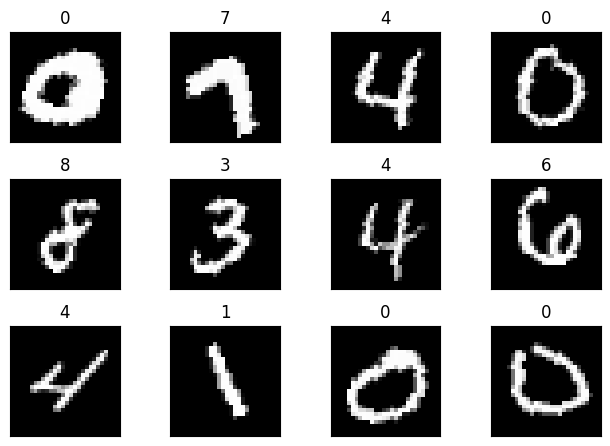

In [29]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [30]:
  class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) #28x28x1  | (3x3x1)32 | 28x28x32 RF 3x3
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1) #28x28x32 | (3x3x32)x32 | 28x28x32 RF 5x5
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1) #14x14x32 | (3x3x32)x16 | 14x14x16 RF 10x10
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1) #14x14x16  | (3x3x16)16 | 14x14x16 RF 12x12
        self.conv5 = nn.Conv2d(16, 8, kernel_size=3, padding=1) #7x7x16  | (3x3x16)x8 | 7x7x8 RF 24x24
        self.conv6 = nn.Conv2d(8, 8, kernel_size=3, padding=1) #7x7x8 | (3x3x8)x8 | 7x7x8 RF 26x26
        self.fc1 = nn.Linear(8 * 7 * 7, 10) #RF 26x26

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1, 8 * 7 * 7)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Training Setup

In [31]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [32]:
# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Shape: [batch_size]
            test_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)  # Average per sample
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [34]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.2869 Batch_id=117 Accuracy=75.34: 100%|██████████| 118/118 [00:17<00:00,  6.93it/s]


Test set: Average loss: 0.1899, Accuracy: 9425/10000 (94.25%)

Epoch 2


Train: Loss=0.2080 Batch_id=117 Accuracy=94.33: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.1052, Accuracy: 9640/10000 (96.40%)

Epoch 3


Train: Loss=0.1382 Batch_id=117 Accuracy=96.30: 100%|██████████| 118/118 [00:17<00:00,  6.85it/s]


Test set: Average loss: 0.0666, Accuracy: 9790/10000 (97.90%)

Epoch 4


Train: Loss=0.0556 Batch_id=117 Accuracy=97.02: 100%|██████████| 118/118 [00:17<00:00,  6.62it/s]


Test set: Average loss: 0.0535, Accuracy: 9833/10000 (98.33%)

Epoch 5


Train: Loss=0.1991 Batch_id=117 Accuracy=97.37: 100%|██████████| 118/118 [00:17<00:00,  6.81it/s]


Test set: Average loss: 0.0468, Accuracy: 9840/10000 (98.40%)

Epoch 6


Train: Loss=0.0752 Batch_id=117 Accuracy=97.87: 100%|██████████| 118/118 [00:17<00:00,  6.71it/s]


Test set: Average loss: 0.0379, Accuracy: 9869/10000 (98.69%)

Epoch 7


Train: Loss=0.0246 Batch_id=117 Accuracy=98.00: 100%|██████████| 118/118 [00:17<00:00,  6.88it/s]


Test set: Average loss: 0.0373, Accuracy: 9870/10000 (98.70%)

Epoch 8


Train: Loss=0.0985 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:17<00:00,  6.84it/s]


Test set: Average loss: 0.0366, Accuracy: 9870/10000 (98.70%)

Epoch 9


Train: Loss=0.0585 Batch_id=117 Accuracy=98.04: 100%|██████████| 118/118 [00:17<00:00,  6.61it/s]


Test set: Average loss: 0.0362, Accuracy: 9871/10000 (98.71%)

Epoch 10


Train: Loss=0.0540 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:18<00:00,  6.44it/s]


Test set: Average loss: 0.0351, Accuracy: 9872/10000 (98.72%)

Epoch 11


Train: Loss=0.1229 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:18<00:00,  6.41it/s]


Test set: Average loss: 0.0346, Accuracy: 9873/10000 (98.73%)

Epoch 12


Train: Loss=0.0189 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:17<00:00,  6.77it/s]


Test set: Average loss: 0.0343, Accuracy: 9875/10000 (98.75%)

Epoch 13


Train: Loss=0.0201 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]


Test set: Average loss: 0.0344, Accuracy: 9875/10000 (98.75%)

Epoch 14


Train: Loss=0.0963 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:17<00:00,  6.72it/s]


Test set: Average loss: 0.0344, Accuracy: 9874/10000 (98.74%)

Epoch 15


Train: Loss=0.0126 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:18<00:00,  6.44it/s]


Test set: Average loss: 0.0339, Accuracy: 9878/10000 (98.78%)

Epoch 16


Train: Loss=0.0763 Batch_id=117 Accuracy=98.12: 100%|██████████| 118/118 [00:17<00:00,  6.82it/s]


Test set: Average loss: 0.0339, Accuracy: 9877/10000 (98.77%)

Epoch 17


Train: Loss=0.0888 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:17<00:00,  6.56it/s]


Test set: Average loss: 0.0340, Accuracy: 9876/10000 (98.76%)

Epoch 18


Train: Loss=0.1244 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:17<00:00,  6.78it/s]


Test set: Average loss: 0.0340, Accuracy: 9876/10000 (98.76%)

Epoch 19


Train: Loss=0.1142 Batch_id=117 Accuracy=98.13: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.0341, Accuracy: 9876/10000 (98.76%)

Epoch 20


Train: Loss=0.0647 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:17<00:00,  6.81it/s]


Test set: Average loss: 0.0340, Accuracy: 9876/10000 (98.76%)



# Test Results

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

# Save and Visualize Model

In [ ]:
torch.save(model, "model.pt") ## does not include details of activation functions

In [ ]:
!pip install onnx
device = torch.device("cuda" if use_cuda else "cpu")

# Create dummy input with the same shape as your input
dummy_input = torch.randn(1, 1, 28, 28).to(device)  # Batch x Channels x Height x Width

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

/tmp/ipython-input-3254252982.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "model.onnx",


In [15]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=392, out_features=10, bias=True)
)

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.4 MB/s eta 0:00:00
